[INFO] (rhi) layer: CreateDevice: Debug layer is enabled.
[WARN] No supported shader model found, pretending to support sm_6_0.


interactive(children=(FloatSlider(value=0.0, description='A', max=1.0), FloatSlider(value=50.0, description='B…

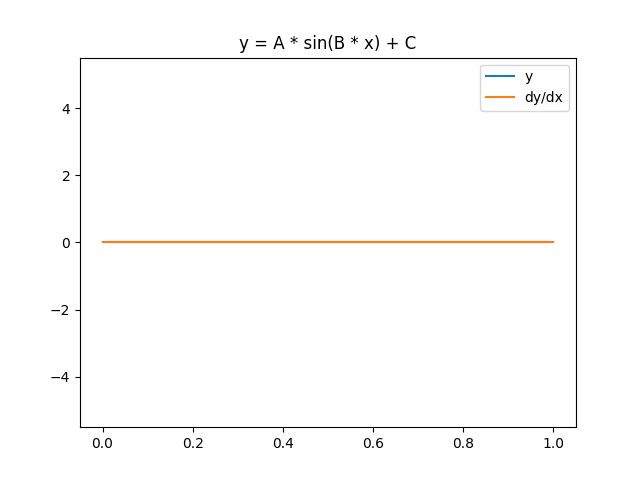

In [1]:
%matplotlib widget
import slangpy as spy
from ipywidgets import *
import numpy as np
import matplotlib.pyplot as plt
import os

DIR = os.path.abspath(os.path.curdir)
device = spy.Device(compiler_options={"include_paths": [DIR]})
program = device.load_program("func.slang", ["compute_main"])  # Changed from "main"
kernel = device.create_compute_kernel(program)

buf_x = device.create_buffer(element_count=1024, resource_type_layout=kernel.reflection.compute_main.buf_x, usage=spy.BufferUsage.shader_resource)
buf_y = device.create_buffer(element_count=1024, resource_type_layout=kernel.reflection.compute_main.buf_y, usage=spy.BufferUsage.unordered_access)
buf_dydx = device.create_buffer(element_count=1024, resource_type_layout=kernel.reflection.compute_main.buf_dydx, usage=spy.BufferUsage.unordered_access)

def eval_func(x, A=0.5, B=10.0, C=0.0):
    buf_x.copy_from_numpy(x)
    kernel.dispatch(thread_count=[1024,1,1], buf_x=buf_x, buf_y=buf_y, buf_dydx=buf_dydx, A=A, B=B, C=C)
    y = buf_y.to_numpy().view(np.float32)
    dydx = buf_dydx.to_numpy().view(np.float32)
    return y, dydx

x = np.linspace(0, 1, 1024, dtype=np.float32)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_title("y = A * sin(B * x) + C")
y, dydx = eval_func(x)
line_y, = ax.plot(x, y, label="y")
line_dydx, = ax.plot(x, dydx, label="dy/dx")
ax.legend(loc="upper right")

def update(A, B, C):
    y, dydx = eval_func(x, A, B, C)
    line_y.set_ydata(y)
    line_dydx.set_ydata(dydx)
    fig.canvas.draw_idle()
    
interact(update, A=(0,1,0.1), B=(0,100,0.1), C=(-5,5,0.1));